In [1]:
!pip install -q -U transformers accelerate bitsandbytes radon ipywidgets matplotlib

print("✅ All required libraries have been installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00
✅ All required libraries have been installed successfully!


# 2. Imports and Global Configuration 📚

In [2]:
# =============================================================================
# 2. Imports and Global Configuration 📚
# =============================================================================

import os
import re
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from radon.visitors import ComplexityVisitor
from radon.metrics import mi_visit
from radon.raw import analyze

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

# --- Hugging Face Token Setup ---
# Tries to get the token from an environment variable.
HF_TOKEN = os.getenv('HF_TOKEN')
if HF_TOKEN:
    print("✅ Hugging Face token loaded successfully from environment variable.")
else:
    print("🚨 Could not load HF_TOKEN. Please ensure it's set as an environment variable.")

# --- Model Definitions ---
# A dictionary mapping a user-friendly name to its Hugging Face model ID.
MODELS = {
    "DeepSeek-Coder-1.3B": "deepseek-ai/deepseek-coder-1.3b-instruct",
    "Phi-2-2.7B": "microsoft/phi-2",
    "Gemma-2B-IT": "google/gemma-2b-it",
    "Stable-Code-3B": "stabilityai/stable-code-3b",
    "Replit-Code-3B": "replit/replit-code-v1-3b",
}

# --- Caching for Loaded Models ---
# This dictionary will store loaded models and tokenizers to avoid reloading them.
loaded_models_cache = {}

print("✅ Imports and configurations are complete.")

🚨 Could not load HF_TOKEN. Please ensure it's set as an environment variable.
✅ Imports and configurations are complete.


# 3. Core Functions: Model Loading, Generation, and Evaluation 🚀

In [3]:
# =============================================================================
# 3. Core Functions: Model Loading, Generation, and Evaluation 🚀
# =============================================================================

# --- Function to Load Model and Tokenizer ---
def load_model_and_tokenizer(model_name):
    """
    Loads a model and tokenizer from Hugging Face with caching.
    Uses bfloat16 for efficiency and device_map='auto' for GPU utilization.
    """
    model_id = MODELS[model_name]
    if model_id in loaded_models_cache:
        print(f"🧠 Loading {model_name} from cache...")
        return loaded_models_cache[model_id]

    print(f"Downloading and loading {model_name}...")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN, trust_remote_code=True)
        # For Phi-2, pad_token is not set by default. We set it to eos_token.
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            token=HF_TOKEN,
            trust_remote_code=True
        )
        loaded_models_cache[model_id] = (model, tokenizer)
        print(f"✅ {model_name} loaded successfully.")
        return model, tokenizer
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")
        return None, None

# --- Function to Generate Code ---
def generate_code(model, tokenizer, prompt):
    """
    Generates code from a given prompt using the specified model and tokenizer.
    """
    print(f"Generating code for prompt: '{prompt[:30]}...'")
    if "gemma" in tokenizer.name_or_path or "deepseek" in tokenizer.name_or_path:
         messages = [{"role": "user", "content": prompt}]
         input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    else:
        input_text = prompt

    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.2,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    code_match = re.search(r"```python\n(.*?)\n```", generated_text, re.DOTALL)
    if code_match:
        return code_match.group(1).strip()
    code_match = re.search(r"```(.*?)```", generated_text, re.DOTALL)
    if code_match:
        return code_match.group(1).strip().lstrip('python\n')
    return generated_text[len(input_text):].strip()

# --- Function to Evaluate Code Quality ---
def evaluate_code(code_string):
    """
    Analyzes a string of Python code using 'radon' and returns quality metrics.
    """
    if not code_string:
        return {"complexity": 0, "mi_score": 0, "loc": 0}
    try:
        visitor = ComplexityVisitor.from_code(code_string)
        total_complexity = sum(f.complexity for f in visitor.functions)
        mi_score = mi_visit(code_string, multi=True)
        raw_analysis = analyze(code_string)
        loc = raw_analysis.lloc
        return {
            "complexity": total_complexity,
            "mi_score": round(mi_score, 2),
            "loc": loc
        }
    except Exception as e:
        print(f"⚠️ Radon analysis failed: {e}")
        return {"complexity": -1, "mi_score": -1, "loc": -1}

print("✅ Core functions defined successfully.")

✅ Core functions defined successfully.


# 4. Visualization Function 📊

In [4]:
# =============================================================================
# 4. Visualization Function 📊
# =============================================================================
# This function creates bar charts to compare model performance.

def plot_metrics(results):
    """
    Generates and displays three bar plots for the collected metrics.
    """
    model_names = list(results.keys())
    model_names = [name for name in model_names if results[name]['metrics']['complexity'] != -1]
    if not model_names:
        print("No valid results to plot.")
        return

    complexity_scores = [results[name]['metrics']['complexity'] for name in model_names]
    mi_scores = [results[name]['metrics']['mi_score'] for name in model_names]
    loc_scores = [results[name]['metrics']['loc'] for name in model_names]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Code Generation Model Performance Comparison', fontsize=16)
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

    ax1.bar(model_names, complexity_scores, color=colors)
    ax1.set_title('Cyclomatic Complexity (Lower is Better)')
    ax1.set_ylabel('Complexity Score')
    ax1.tick_params(axis='x', rotation=45)

    ax2.bar(model_names, mi_scores, color=colors)
    ax2.set_title('Maintainability Index (Higher is Better)')
    ax2.set_ylabel('MI Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, 100)

    ax3.bar(model_names, loc_scores, color=colors)
    ax3.set_title('Logical Lines of Code (LOC)')
    ax3.set_ylabel('Number of Lines')
    ax3.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("✅ Visualization function defined successfully.")

✅ Visualization function defined successfully.


# 5. Sample Prompts for Testing 🧪

In [5]:
# =============================================================================
# 5. Sample Prompts for Testing 🧪
# =============================================================================
# A list of diverse prompts to test the models.

SAMPLE_PROMPTS = [
    # Python / Data Science
    "Write a Python function that takes a pandas DataFrame and returns the correlation matrix for its numeric columns.",
    "Generate a Python script to scrape the headlines from the BBC News homepage using BeautifulSoup.",
    "Create a Python function to implement the bubble sort algorithm.",
    # Web Development
    "Write a simple HTML page with a form that has fields for 'name', 'email' and a 'submit' button.",
    "Generate a JavaScript function that fetches data from an API endpoint and logs the JSON response to the console.",
    # Database
    "Write a SQL query to find all employees who earn more than the average salary of their respective departments.",
    "Write a SQL query to select the top 5 most sold products from a 'sales' table.",
    # General Purpose / DevOps
    "Create a Python function that lists all files in a directory and its subdirectories.",
    "Write a simple Dockerfile for a basic Python Flask application.",
    # Algorithmic
    "Write a Python function to find the factorial of a number using recursion."
]

print(f"✅ {len(SAMPLE_PROMPTS)} sample prompts are ready.")

✅ 10 sample prompts are ready.


# 6. Interactive UI #1: Benchmark All Models ⚡️

🚀 Starting benchmark for prompt: 'Create a Python function to implement the bubble sort algorithm.'
--- Processing Model: DeepSeek-Coder-1.3B ---
🧠 Loading DeepSeek-Coder-1.3B from cache...
Generating code for prompt: 'Create a Python function to im...'

✨ Generated Code:
```python
def bubble_sort(arr):
    n = len(arr)

    for i in range(n):
        for j in range(0, n - i - 1):
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]

    return arr
```

📊 Metrics: {'complexity': 4, 'mi_score': 68.59, 'loc': 7}

----------------------------------------------------

--- Processing Model: Phi-2-2.7B ---
🧠 Loading Phi-2-2.7B from cache...
Generating code for prompt: 'Create a Python function to im...'

✨ Generated Code:
```python
def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(0, n-i-1):
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr
```

📊 Metrics: {'complexity

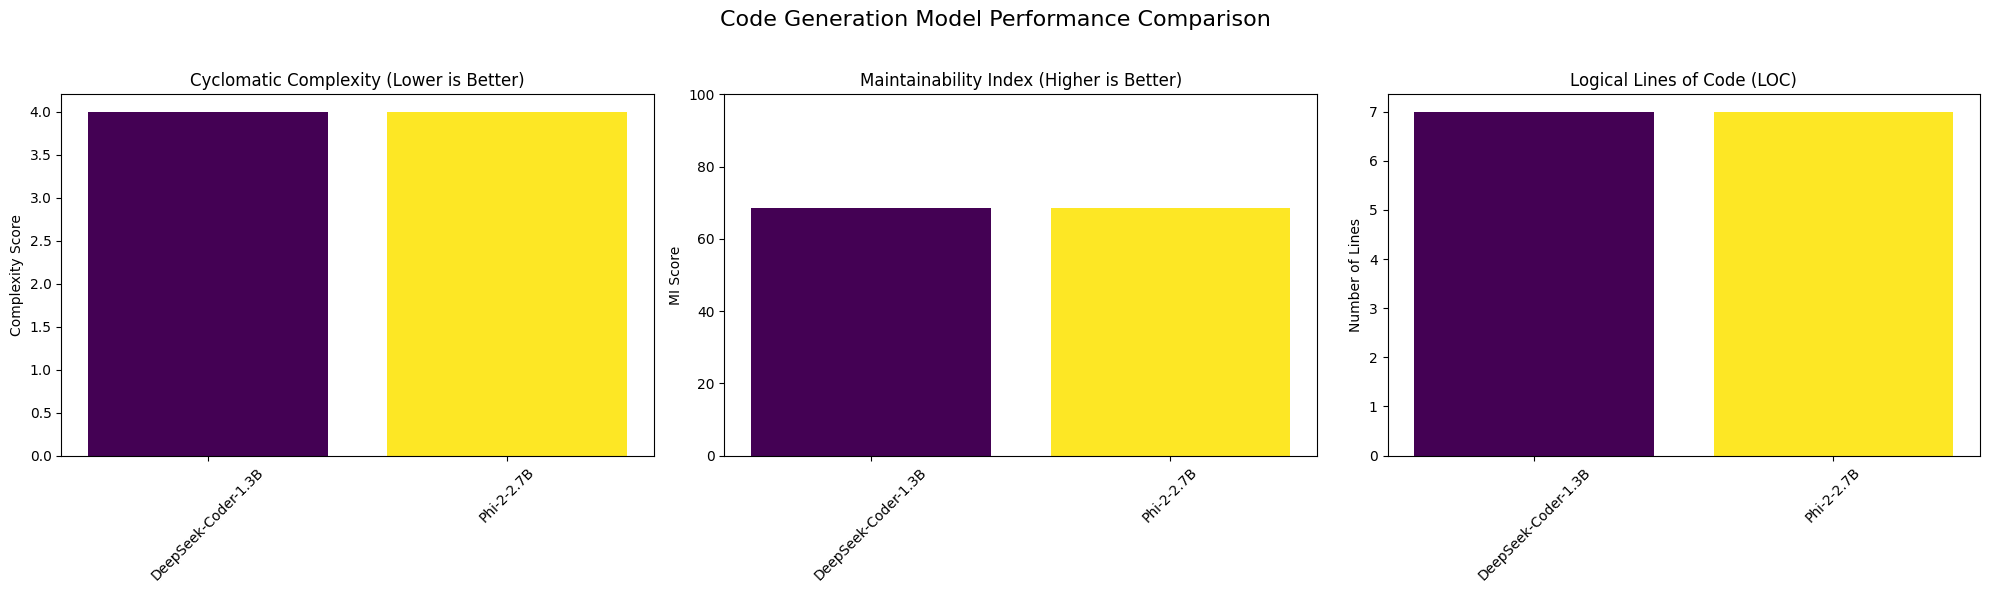

In [6]:
# =============================================================================
# 6. Interactive UI #1: Benchmark All Models ⚡️
# =============================================================================
# This UI benchmarks all 5 models for a given prompt.

# --- UI Widgets ---
prompt_input_1 = widgets.Dropdown(
    options=SAMPLE_PROMPTS,
    description='Prompt:',
    style={'description_width': 'initial'},
    layout={'width': '95%'}
)
custom_prompt_input_1 = widgets.Textarea(
    placeholder='Or type your own custom prompt here...',
    layout={'width': '95%', 'height': '80px'}
)
benchmark_button = widgets.Button(description="Benchmark All Models", button_style='success')
output_1 = widgets.Output()

# --- Event Handler ---
def on_benchmark_button_clicked(b):
    with output_1:
        clear_output(wait=True)
        prompt = custom_prompt_input_1.value if custom_prompt_input_1.value else prompt_input_1.value
        if not prompt:
            print("🚨 Please select or enter a prompt.")
            return

        print(f"🚀 Starting benchmark for prompt: '{prompt}'\n" + "="*52)
        results = {}
        for model_name in MODELS.keys():
            print(f"--- Processing Model: {model_name} ---")
            model, tokenizer = load_model_and_tokenizer(model_name)
            if model is None: continue

            generated_code = generate_code(model, tokenizer, prompt)
            metrics = evaluate_code(generated_code)
            results[model_name] = {"code": generated_code, "metrics": metrics}

            print(f"\n✨ Generated Code:\n```python\n{generated_code}\n```")
            print(f"\n📊 Metrics: {metrics}")
            print("\n" + "-"*52 + "\n")

        print("📈 Generating performance plots...")
        plot_metrics(results)

benchmark_button.on_click(on_benchmark_button_clicked)

# --- Display UI ---
print("UI #1 is ready. Choose a prompt and click the button to start.")
display(prompt_input_1, custom_prompt_input_1, benchmark_button, output_1)

# 7. Interactive UI #2: Inspect Models with Checkboxes ✅

🚀 Starting inspection for prompt: 'Create a Python function to implement the bubble sort algorithm.'
Models selected: DeepSeek-Coder-1.3B, Phi-2-2.7B, Gemma-2B-IT, Stable-Code-3B, Replit-Code-3B
--- Processing Model: DeepSeek-Coder-1.3B ---
🧠 Loading DeepSeek-Coder-1.3B from cache...
Generating code for prompt: 'Create a Python function to im...'

✨ Generated Code:
```python
def bubble_sort(arr):
    n = len(arr)

    for i in range(n):
        for j in range(0, n - i - 1):
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]

    return arr
```

📊 Metrics: {'complexity': 4, 'mi_score': 68.59, 'loc': 7}

----------------------------------------------------

--- Processing Model: Phi-2-2.7B ---
🧠 Loading Phi-2-2.7B from cache...
Generating code for prompt: 'Create a Python function to im...'

✨ Generated Code:
```python
def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(0, n-i-1):
            if arr[j] > arr[j+1]:


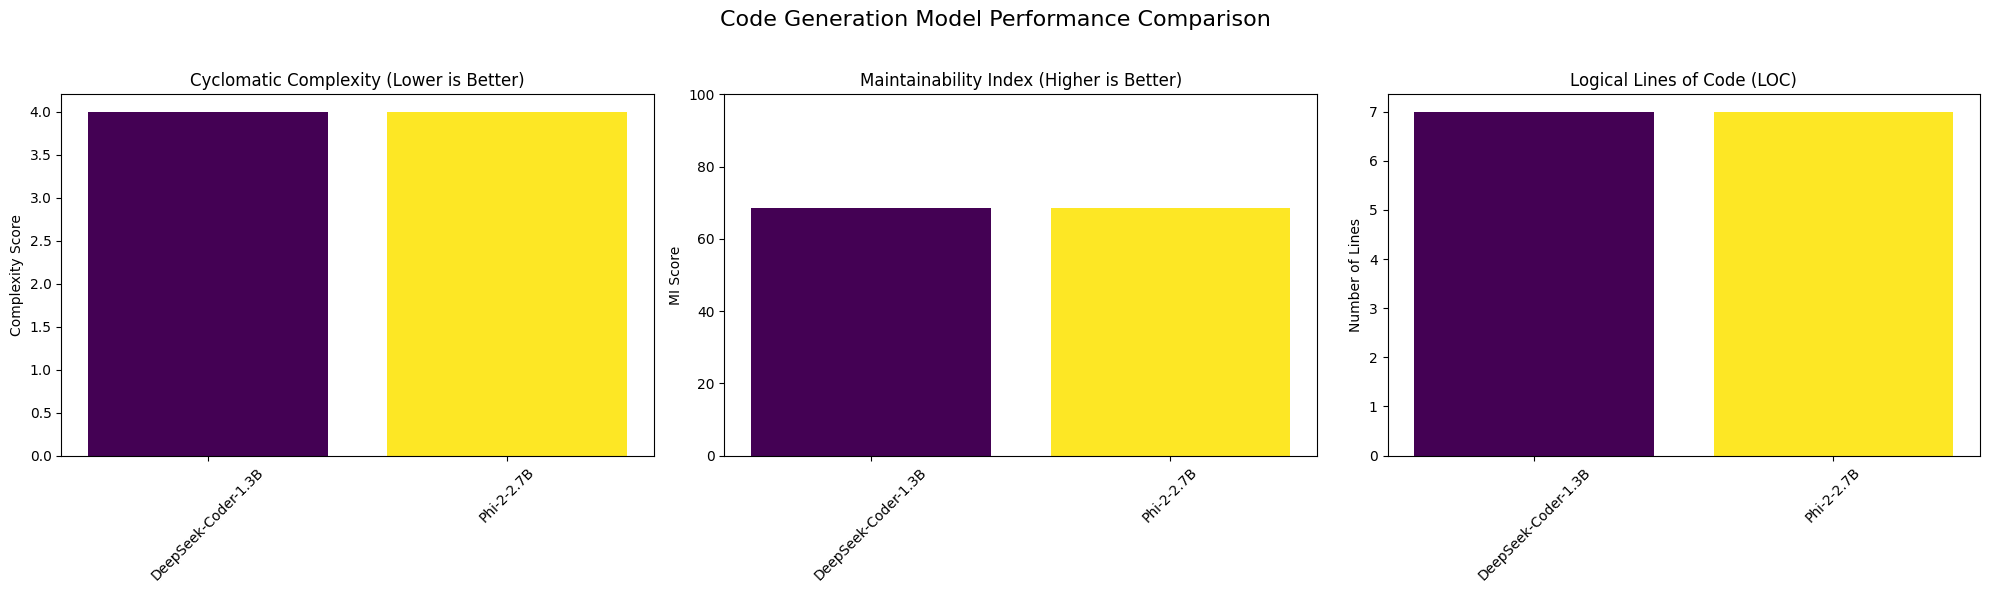

In [7]:
# =============================================================================
# 7. Interactive UI #2: Inspect Models with Checkboxes ✅
# =============================================================================
# This UI allows you to select specific models to compare.

# --- UI Widgets ---
prompt_input_2 = widgets.Dropdown(
    options=SAMPLE_PROMPTS,
    description='Prompt:',
    style={'description_width': 'initial'},
    layout={'width': '95%'}
)
custom_prompt_input_2 = widgets.Textarea(
    placeholder='Or type your own custom prompt here...',
    layout={'width': '95%', 'height': '80px'}
)
model_checkboxes = [widgets.Checkbox(value=True, description=name) for name in MODELS.keys()]
checkbox_container = widgets.HBox(model_checkboxes)
inspect_button = widgets.Button(description="Generate & Inspect Selected", button_style='primary')
output_2 = widgets.Output()

# --- Event Handler ---
def on_inspect_button_clicked(b):
    with output_2:
        clear_output(wait=True)
        prompt = custom_prompt_input_2.value if custom_prompt_input_2.value else prompt_input_2.value
        if not prompt:
            print("🚨 Please select or enter a prompt.")
            return

        selected_models = [cb.description for cb in model_checkboxes if cb.value]
        if not selected_models:
            print("🚨 Please select at least one model to inspect.")
            return

        print(f"🚀 Starting inspection for prompt: '{prompt}'")
        print(f"Models selected: {', '.join(selected_models)}\n" + "="*52)
        results = {}
        for model_name in selected_models:
            print(f"--- Processing Model: {model_name} ---")
            model, tokenizer = load_model_and_tokenizer(model_name)
            if model is None: continue

            generated_code = generate_code(model, tokenizer, prompt)
            metrics = evaluate_code(generated_code)
            results[model_name] = {"code": generated_code, "metrics": metrics}

            print(f"\n✨ Generated Code:\n```python\n{generated_code}\n```")
            print(f"\n📊 Metrics: {metrics}")
            print("\n" + "-"*52 + "\n")

        print("📈 Generating performance plots...")
        plot_metrics(results)

inspect_button.on_click(on_inspect_button_clicked)

# --- Display UI ---
print("\n\nUI #2 is ready. Choose a prompt, select models, and click the button.")
display(prompt_input_2, custom_prompt_input_2, checkbox_container, inspect_button, output_2)